In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np

# Define your column names in a list
column_names = ['Datetime', 'OrderID', 'ProductID', 'Quantity', 'CategoryID', 
                'CategoryCode', 'BrandID', 'USDPrice', 'UserID', 
                'Gender', 'Color', 'Metal', 'Gem','Country']


df = pd.read_csv('C:\\Users\\RebeccaOseiAkoto\\e-comjewerly.csv', names=column_names,low_memory=False)
# Select only numeric columns for mean calculation
numeric_df = df.select_dtypes(include=[np.number])
mean = numeric_df.mean()

# Fill missing values in numeric columns
df.fillna(mean, inplace=True)
df.head(10)
print(df)

                      Datetime       OrderID     ProductID  Quantity  \
0      2018-12-01 11:40:29 UTC  1.920000e+18  1.840000e+18      12.0   
1      2018-12-01 17:38:31 UTC  1.920000e+18  1.810000e+18      36.0   
2      2018-12-02 13:53:42 UTC  1.930000e+18  1.840000e+18      12.0   
3      2018-12-02 17:44:02 UTC  1.930000e+18  1.840000e+18      12.0   
4      2018-12-02 21:30:19 UTC  1.930000e+18  1.870000e+18       6.0   
...                        ...           ...           ...       ...   
95906  2021-12-01 09:47:37 UTC  2.720000e+18  1.520000e+18       6.0   
95907  2021-12-01 09:50:37 UTC  2.720000e+18  1.960000e+18       6.0   
95908  2021-12-01 09:52:06 UTC  2.720000e+18  1.960000e+18      12.0   
95909  2021-12-01 09:55:35 UTC  2.720000e+18  1.840000e+18      10.0   
95910  2021-12-01 09:59:07 UTC  2.720000e+18  1.960000e+18       4.0   

         CategoryID      CategoryCode       BrandID    USDPrice        UserID  \
0      1.810000e+18   jewelry.earring  0.000000e+00  5

<Axes: xlabel='Gender', ylabel='count'>

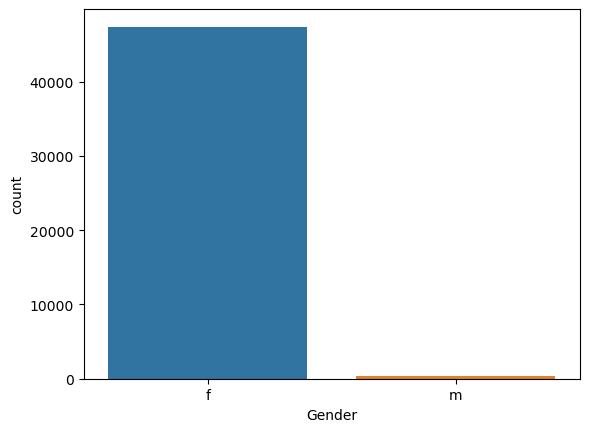

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data = df, x = 'Gender')

In [3]:
print(df.columns)

Index(['Datetime', 'OrderID', 'ProductID', 'Quantity', 'CategoryID',
       'CategoryCode', 'BrandID', 'USDPrice', 'UserID', 'Gender', 'Color',
       'Metal', 'Gem', 'Country'],
      dtype='object')


In [4]:
df.Gender.fillna('f', inplace=True)
df.info()
df.CategoryCode.fillna('other', inplace=True)
df['BrandID'].fillna('-1',inplace=True)
df['Gem'].unique()
for i in ('Color','Metal','Gem'):
  if i == 'Color':
    df[i].fillna('unknown-color',inplace=True)
  else:
    df[i].fillna('unknown',inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95911 entries, 0 to 95910
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Datetime      95911 non-null  object 
 1   OrderID       95911 non-null  float64
 2   ProductID     95911 non-null  float64
 3   Quantity      95911 non-null  float64
 4   CategoryID    95911 non-null  float64
 5   CategoryCode  85978 non-null  object 
 6   BrandID       95911 non-null  float64
 7   USDPrice      95911 non-null  float64
 8   UserID        95911 non-null  float64
 9   Gender        95911 non-null  object 
 10  Color         88251 non-null  object 
 11  Metal         90449 non-null  object 
 12  Gem           61853 non-null  object 
 13  Country       95911 non-null  object 
dtypes: float64(7), object(7)
memory usage: 10.2+ MB


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import datetime as dt


# Ensure that 'Datetime' is a datetime object and 'USDPrice' is float
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['USDPrice'] = df['USDPrice'].astype(float)

# Current date for recency calculation (assuming the latest date in the dataset + 1 day)
current_date = df['Datetime'].max() + dt.timedelta(days=1)

# RFM Calculation
rfm = df.groupby('UserID').agg({
    'Datetime': lambda x: (current_date - x.max()).days,  # Recency
    'OrderID': 'count',                                   # Frequency
    'USDPrice': 'sum'                                     # Monetary
})

# Renaming columns for clarity
rfm.columns = ['Recency (Days)', 'Frequency (orders)', 'Monetary(USD)']


# Checking the first few rows of the RFM DataFrame
rfm.head()


,Recency (Days),Frequency (orders),Monetary(USD)
UserID,,,
1.310000e+18,21,277,102452.13
1.320000e+18,1,441,153919.99
1.330000e+18,10,321,120457.90
1.340000e+18,45,120,48179.17
1.350000e+18,22,74,19918.57


In [56]:
from sklearn.cluster import KMeans
import numpy as np

# Calculating the average scores for Recency, Frequency, and Monetary
rfm_avg = rfm.mean()

# Normalizing the RFM data
rfm_normalized = (rfm - rfm.mean()) / rfm.std()

# Using KMeans to cluster the data
kmeans = KMeans(n_clusters=4, random_state=1)
rfm['Cluster'] = kmeans.fit_predict(rfm_normalized)

# Calculating the average values for each cluster
cluster_avg = rfm.groupby('Cluster').mean()

# Combining overall averages with cluster averages
combined_avg = cluster_avg.copy()
combined_avg.loc['Overall'] = rfm_avg

combined_avg.reset_index(inplace=True)

combined_avg, rfm_normalized.head()


(   Cluster  Recency (Days)  Frequency (orders)  Monetary(USD)
 0        0       16.133333              532.60   1.946762e+05
 1        1        1.000000            87630.00   3.172226e+07
 2        2      125.000000               63.00   1.722036e+04
 3        3      401.000000              103.00   4.636014e+04
 4  Overall       50.950000             4795.55   1.737021e+06,
               Recency (Days)  Frequency (orders)  Monetary(USD)
 UserID                                                         
 1.310000e+18       -0.322639           -0.231342      -0.231185
 1.320000e+18       -0.538090           -0.222945      -0.223906
 1.330000e+18       -0.441137           -0.229089      -0.228638
 1.340000e+18       -0.064097           -0.239380      -0.238861
 1.350000e+18       -0.311866           -0.241735      -0.242858)

In [63]:
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
# Scaling the RFM data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency (Days)', 'Frequency (orders)', 'Monetary(USD)']])

# Assume you have determined the number of clusters to be 3 for 'top', 'medium', and 'low' segments
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Analyze the centroids to label the segments
centroids = kmeans.cluster_centers_
# Sort the centroids by Monetary value (or another criterion you deem important for segmentation)
sorted_idx = centroids[:, 2].argsort()

# Assign segment labels based on the sorted index
segment_labels = {sorted_idx[0]: 'Low', sorted_idx[1]: 'Medium', sorted_idx[2]: 'Top'}
rfm['Segment'] = rfm['Cluster'].map(segment_labels)

# You can now use the 'Segment' column in your plot or further analysis

fig = go.Figure(data=[go.Scatter3d(
    x=rfm['Recency (Days)'],
    y=rfm['Frequency (orders)'],
    z=rfm['Monetary(USD)'],
    mode='markers',
    marker=dict(
        size=5,
        color=rfm['Segment'].map({'Top': 'green', 'Medium': 'yellow', 'Low': 'red'}),  # color by segment
        opacity=0.8
    ),
    text=rfm.index  # UserIDs as hover text
)])

# Setting the layout for the 3D plot
fig.update_layout(
    title="RFM Segmentation with Top, Medium, and Low Segments",
    scene=dict(
        xaxis_title='Recency',
        yaxis_title='Frequency',
        zaxis_title='Monetary'
    ),
    margin=dict(l=0, r=0, b=0, t=0)  # tight layout
)

# Showing the figure
fig.show()

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler


# Convert 'Datetime' to datetime format and create additional time features
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Datetime'] = df['Datetime'].dt.tz_localize(None)
df['Month'] = df['Datetime'].dt.month
df['Year'] = df['Datetime'].dt.year

# Aggregate data at the customer level
customer_df = df.groupby('UserID').agg(
    Total_Spend=('USDPrice', 'sum'),
    Average_Spend=('USDPrice', 'mean'),
    Total_Orders=('OrderID', 'nunique'),
    Total_Items=('Quantity', 'sum'),
    Recency=('Datetime', lambda x: (pd.Timestamp.now() - x.max()).days),
    # Include other features that might be relevant
).reset_index()

# Assuming you have another DataFrame 'rfm' with RFM scores already calculated
# customer_df = customer_df.merge(rfm, on='UserID', how='left')

# Create a dummy target variable for demonstration purposes
# In practice, this should be based on your specific business logic
customer_df['Will_Purchase_Next_Month'] = (customer_df['Total_Orders'] % 2).astype(int)

# Split the dataset into features (X) and target (y)
X = customer_df.drop(['UserID', 'Will_Purchase_Next_Month'], axis=1)
y = customer_df['Will_Purchase_Next_Month']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test_scaled)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[1 2]
 [0 3]]
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.60      1.00      0.75         3

    accuracy                           0.67         6
   macro avg       0.80      0.67      0.62         6
weighted avg       0.80      0.67      0.62         6



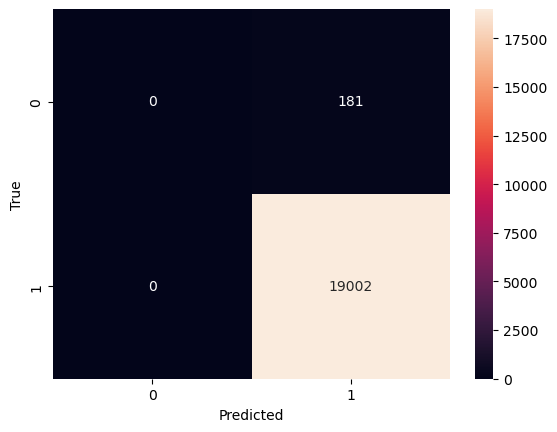

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [18]:



# Check the distribution of the target class
class_distribution = df['CategoryCode'].value_counts()
print(class_distribution)


CategoryCode
jewelry.earring     29052
jewelry.ring        28300
jewelry.pendant     13088
other                9933
jewelry.bracelet     6188
Name: count, dtype: int64


In [19]:
# Keep only rows where CategoryCode is a valid category
valid_categories = ['jewelry.earring', 'jewelry.ring', 'jewelry.pendant', 'other', 'jewelry.bracelet']  # Add other valid categories
df = df[df['CategoryCode'].isin(valid_categories)]

# Check the distribution again
print(df['CategoryCode'].value_counts())



CategoryCode
jewelry.earring     29052
jewelry.ring        28300
jewelry.pendant     13088
other                9933
jewelry.bracelet     6188
Name: count, dtype: int64


In [20]:
from sklearn.utils import resample

# Filter out categories that do not exist in the DataFrame
valid_categories = [cat for cat in valid_categories if cat in df['CategoryCode'].unique()]

# Ensure that there is at least one sample in each category
if not valid_categories:
    raise ValueError("No valid categories found in DataFrame.")

# Calculate the size of the largest category
majority_class_size = df['CategoryCode'].value_counts().loc[valid_categories].max()

# Upsample minority classes
df_upsampled_list = []
for category in valid_categories:
    df_category = df[df.CategoryCode == category]
    df_category_upsampled = resample(df_category, 
                                     replace=True,     
                                     n_samples=majority_class_size,    
                                     random_state=123)
    df_upsampled_list.append(df_category_upsampled)

# Combine upsampled dataframes
df_upsampled = pd.concat(df_upsampled_list)

# Check new class distribution
print(df_upsampled.CategoryCode.value_counts())



CategoryCode
jewelry.earring     29052
jewelry.ring        29052
jewelry.pendant     29052
other               29052
jewelry.bracelet    29052
Name: count, dtype: int64


In [21]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Assuming df is your DataFrame after addressing class imbalance

# Select columns for feature engineering
categorical_features = ['Gender', 'Color', 'Metal', 'Gem']  # Add other categorical columns
numerical_features = ['Quantity', 'USDPrice']  # Add other numerical columns

# Create transformers for categorical and numerical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = StandardScaler()

# Create a column transformer to apply transformations to the respective columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Prepare features and target variable
X = df.drop(['CategoryCode', 'OrderID', 'ProductID', 'UserID', 'Datetime'], axis=1)
y = df['CategoryCode']


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Prepare features and target variable
X = df_upsampled.drop(['CategoryCode'], axis=1)  # Include relevant features
y = df_upsampled['CategoryCode']

# Encoding and scaling
categorical_features = ['Gender', 'Color', 'Metal', 'Gem']  # Update as per your dataset
numerical_features = ['Quantity', 'USDPrice']  # Update as per your dataset

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train the model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


                  precision    recall  f1-score   support

jewelry.bracelet       0.93      0.97      0.95      8746
 jewelry.earring       0.83      0.76      0.79      8700
 jewelry.pendant       0.86      0.91      0.88      8621
    jewelry.ring       0.84      0.81      0.82      8842
           other       0.98      0.99      0.98      8669

        accuracy                           0.89     43578
       macro avg       0.89      0.89      0.89     43578
    weighted avg       0.89      0.89      0.89     43578



In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


# Prepare the features by selecting only numeric columns for scaling
numeric_features = customer_df.select_dtypes(include=['int64', 'float64'])

# Prepare the target variable
y = customer_df['Average_Spend']

# Drop the non-numeric and target columns from features
X = numeric_features.drop(['Total_Spend', 'Average_Spend'], axis=1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_regressor.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_regressor.predict(X_test_scaled)

# Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')


Mean Squared Error: 464.49579732730945
R2 Score: 0.7848946424396963


In [24]:
import pandas as pd

# Filter the dataset to include only the relevant categories
categories = ['jewelry.bracelet', 'jewelry.earring', 'jewelry.pendant', 'jewelry.ring', 'other']
df_filtered = df[df['CategoryCode'].isin(categories)]

# Define features and target
features = ['Quantity', 'CategoryCode', 'Gender', 'Color', 'Metal', 'Gem']
target = 'USDPrice'



In [25]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Define categorical and numerical features
categorical_features = ['CategoryCode', 'Gender', 'Color', 'Metal', 'Gem']
numerical_features = ['Quantity']

# Create transformers for categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Prepare features and target variable
X = df_filtered.drop(target, axis=1)
y = df_filtered[target]



In [26]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train the model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])
model.fit(X_train, y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Quantity']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['CategoryCode', 'Gender',
                                                   'Color', 'Metal',
                                                   'Gem'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [27]:
# Example user data for different types of jewelry
user_data_examples = [
    {'CategoryCode': 'jewelry.bracelet', 'Quantity': 1, 'Gender': 'Female', 'Color': 'Gold', 'Metal': 'Gold', 'Gem': 'Diamond'},
    {'CategoryCode': 'jewelry.earring', 'Quantity': 1, 'Gender': 'Female', 'Color': 'Silver', 'Metal': 'Silver', 'Gem': 'Diamond'},
    {'CategoryCode': 'jewelry.pendant', 'Quantity': 1, 'Gender': 'Female', 'Color': 'Gold', 'Metal': 'Gold', 'Gem': 'Emerald'},
    {'CategoryCode': 'jewelry.ring', 'Quantity': 1, 'Gender': 'Female', 'Color': 'Rose Gold', 'Metal': 'Rose Gold', 'Gem': 'Ruby'},
    {'CategoryCode': 'other', 'Quantity': 1, 'Gender': 'Unisex', 'Color': 'Multicolor', 'Metal': 'Mixed', 'Gem': 'None'}
]

# Predict for each type of jewelry
for user_data in user_data_examples:
    user_df = pd.DataFrame([user_data])
    predicted_spend = model.predict(user_df)
    print(f"Predicted amount to be spent on {user_data['CategoryCode']}: ${predicted_spend[0]:.2f}")



Predicted amount to be spent on jewelry.bracelet: $141.40
Predicted amount to be spent on jewelry.earring: $233.62
Predicted amount to be spent on jewelry.pendant: $301.05
Predicted amount to be spent on jewelry.ring: $347.99
Predicted amount to be spent on other: $194.89


In [64]:
!pip install plotly


In [36]:
print(df.columns)

Index(['OrderID', 'ProductID', 'Quantity', 'CategoryID', 'CategoryCode',
       'BrandID', 'USDPrice', 'UserID', 'Gender', 'Color', 'Metal', 'Gem',
       'Country', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')


In [40]:
df.info()
df.describe(include= 'all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95911 entries, 0 to 95910
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OrderID       95911 non-null  float64
 1   ProductID     95911 non-null  float64
 2   Quantity      95794 non-null  float64
 3   CategoryID    90559 non-null  float64
 4   CategoryCode  95911 non-null  int32  
 5   BrandID       91126 non-null  float64
 6   USDPrice      90559 non-null  float64
 7   UserID        90559 non-null  float64
 8   Gender        95911 non-null  int32  
 9   Color         95911 non-null  int32  
 10  Metal         95911 non-null  int32  
 11  Gem           95911 non-null  int32  
 12  Country       95911 non-null  int32  
 13  Year          95911 non-null  int32  
 14  Month         95911 non-null  int32  
 15  Day           95911 non-null  int32  
 16  Hour          95911 non-null  int32  
dtypes: float64(7), int32(10)
memory usage: 8.8 MB


,OrderID,ProductID,Quantity,CategoryID,CategoryCode,BrandID,USDPrice,UserID,Gender,Color,Metal,Gem,Country,Year,Month,Day,Hour
count,9.591100e+04,9.591100e+04,95794.000000,9.055900e+04,95911.000000,9.112600e+04,90559.000000,9.055900e+04,95911.000000,95911.000000,95911.000000,95911.000000,95911.000000,95911.000000,95911.000000,95911.000000,95911.000000
mean,2.485202e+18,1.818768e+18,9.600184,1.809106e+18,202.855001,8.914580e+16,362.215217,1.516588e+18,1.008226,1.744836,0.199331,18.362315,21.960828,2020.460813,7.356768,16.604644,12.144134
std,1.935255e+17,2.138343e+17,266.213471,2.112882e+16,46.165711,3.569103e+17,444.155706,2.430700e+16,0.998072,1.295841,0.727846,10.079483,3.837049,0.713050,3.443492,8.774976,4.629203
min,1.920000e+18,1.310000e+18,-18.000000,1.310000e+18,0.000000,0.000000e+00,0.990000,1.310000e+18,0.000000,0.000000,0.000000,0.000000,0.000000,2018.000000,1.000000,1.000000,0.000000
25%,2.380000e+18,1.520000e+18,1.000000,1.810000e+18,212.000000,0.000000e+00,145.620000,1.520000e+18,0.000000,1.000000,0.000000,8.000000,23.000000,2020.000000,4.000000,9.000000,9.000000
50%,2.520000e+18,1.960000e+18,3.000000,1.810000e+18,214.000000,1.000000e+00,258.770000,1.520000e+18,2.000000,1.000000,0.000000,14.000000,23.000000,2021.000000,8.000000,17.000000,12.000000
75%,2.640000e+18,1.960000e+18,10.000000,1.810000e+18,215.000000,1.000000e+00,431.370000,1.520000e+18,2.000000,3.000000,0.000000,30.000000,23.000000,2021.000000,11.000000,24.000000,16.000000
max,2.720000e+18,2.540000e+18,80995.000000,1.810000e+18,218.000000,1.550000e+18,34448.600000,1.550000e+18,2.000000,5.000000,3.000000,30.000000,23.000000,2021.000000,12.000000,31.000000,23.000000


In [41]:
df.head()

,OrderID,ProductID,Quantity,CategoryID,CategoryCode,BrandID,USDPrice,UserID,Gender,Color,Metal,Gem,Country,Year,Month,Day,Hour
0,1.920000e+18,1.840000e+18,12.0,1.810000e+18,212,0.0,561.51,1.520000e+18,2,1,0,8,23,2018,12,1,11
1,1.920000e+18,1.810000e+18,36.0,1.810000e+18,218,NaN,212.14,1.520000e+18,2,4,0,30,23,2018,12,1,17
2,1.930000e+18,1.840000e+18,12.0,1.810000e+18,214,1.0,54.66,1.520000e+18,0,3,0,23,23,2018,12,2,13
3,1.930000e+18,1.840000e+18,12.0,1.810000e+18,214,0.0,88.90,1.520000e+18,0,1,0,8,23,2018,12,2,17
4,1.930000e+18,1.870000e+18,6.0,1.810000e+18,213,0.0,417.67,1.520000e+18,2,1,0,2,23,2018,12,2,21


In [42]:
df[['USDPrice']].describe()

,USDPrice
count,90559.000000
mean,362.215217
std,444.155706
min,0.990000
25%,145.620000
50%,258.770000
75%,431.370000
max,34448.600000


In [43]:
!pip install pandas numpy statsmodels


In [72]:
!pip install -U scikit-learn imbalanced-learn


  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/4e/ba/ce9bd1cd4953336a0e213b29cb80bb11816f2a93de8c99f88ef0b446ad0c/scikit_learn-1.3.2-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/a3/9e/fbe60a768502af54563dcb59ca7856f5a8833b3ad5ada658922e1ab09b7f/imbalanced_learn-0.11.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/9.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.2 MB 640.0 kB/s eta 0:00:15
   - -------------------------------------- 0.3/9.2 MB 2.9 MB/s eta 0:00:04
   ----- ---------------------------------- 1.2/9.2 MB 9.2 MB/s eta 0:00:01
   ---------- ----------------------------- 2.5/9.2 MB 13.0 MB/s eta 0:00:01
   ----------------- ---------------------- 4.1/9.2 MB 17.4 MB/s eta 0:00:01
   ----------------------- ---------------- 5.4/9.2 MB 21.4 MB/s eta 0:00:01
   -------------------------------

In [81]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Create a binary 'Purchase' indicator based on 'Quantity'
df['Purchase'] = df['Quantity'].apply(lambda x: 1 if x > 0 else 0)

# Selecting features for the model
X = df[['USDPrice']]  # Predictor variable(s)
y = df['Purchase']    # Response variable

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Creating the SVM model
model = SVC(kernel='linear') 
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[    0   181]
 [    0 19002]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       181
           1       0.99      1.00      1.00     19002

    accuracy                           0.99     19183
   macro avg       0.50      0.50      0.50     19183
weighted avg       0.98      0.99      0.99     19183



In [82]:
import statsmodels.api as sm


# Create a binary 'Purchase' indicator based on 'Quantity'
df['Purchase'] = np.where(df['Quantity'] > 0, 1, 0)

# Selecting relevant columns for the model
X = df[['USDPrice']]  # Predictor variable(s)
y = df['Purchase']    # Response variable

# Adding a constant to the model (intercept)
X = sm.add_constant(X)

# Building the logistic regression model with regularization
model = sm.Logit(y, X)
result = model.fit_regularized(method='l1')  # L1 regularization



# Output the summary of the model
print(result.summary())

# Calculating elasticity
# Note: This is a simplification, as elasticity can vary across different price points
df['prob'] = result.predict(X)
df['elasticity'] = df['prob'] * (1 - df['prob']) * df['USDPrice']

# Average elasticity
avg_elasticity = df['elasticity'].mean()
print(f"Average Price Elasticity of Purchase Probability: {avg_elasticity}")




Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0575228415399175
            Iterations: 18
            Function evaluations: 25
            Gradient evaluations: 18
                           Logit Regression Results                           
Dep. Variable:               Purchase   No. Observations:                95911
Model:                          Logit   Df Residuals:                    95909
Method:                           MLE   Df Model:                            1
Date:                Tue, 09 Jan 2024   Pseudo R-squ.:               1.786e-05
Time:                        15:15:22   Log-Likelihood:                -5517.1
converged:                       True   LL-Null:                       -5517.2
Covariance Type:            nonrobust   LLR p-value:                    0.6571
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------


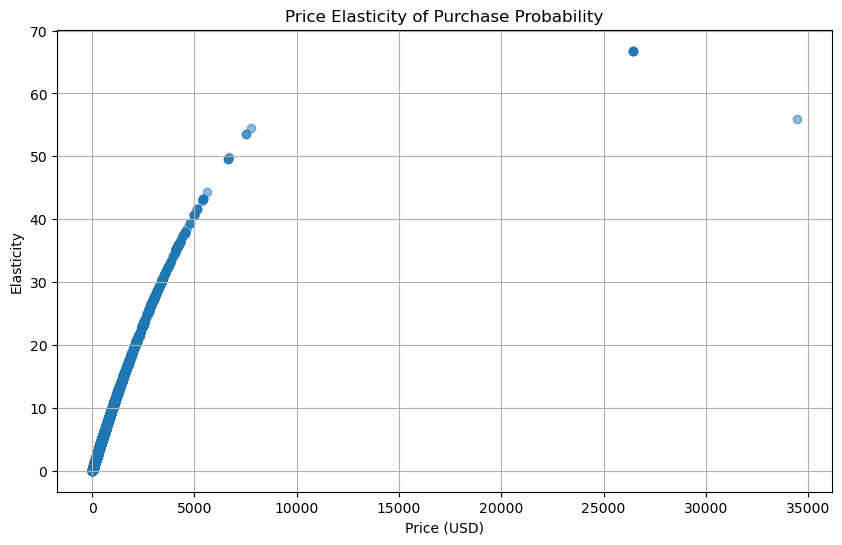

In [111]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and it contains 'USDPrice' and 'elasticity' columns
# Make sure to run the logistic regression and elasticity calculation code before this

plt.figure(figsize=(10, 6))
plt.scatter(df['USDPrice'], df['elasticity'], alpha=0.5)
plt.title('Price Elasticity of Purchase Probability')
plt.xlabel('Price (USD)')
plt.ylabel('Elasticity')
plt.grid(True)
plt.show()


In [ ]:
pip install pandas scikit-learn


In [67]:
pip install imbalanced-learn


In [83]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np


df['Datetime'] = pd.to_datetime(df['Datetime']).dt.tz_localize(None)

# Sort the data by customer and date
df.sort_values(['UserID', 'Datetime'], inplace=True)

# Define a function to create sequences for each customer
def create_sequences(df, sequence_length):
    sequences = []
    targets = []
    customers = df['UserID'].unique()

    for customer in customers:
        customer_data = df[df['UserID'] == customer]
        for i in range(len(customer_data) - sequence_length):
            seq = customer_data.iloc[i:i+sequence_length]  # Sequence of purchases
            target = customer_data.iloc[i+sequence_length]  # Next purchase
            sequences.append(seq[['Quantity', 'USDPrice']].values)  # Example features
            targets.append(target['Quantity'])  # Example target
            # Note: Adjust the features and target as per your requirement
    
    return sequences, targets

# Define your sequence length
sequence_length = 10  # For example, last 10 transactions

# Create sequences and targets
X, y = create_sequences(df, sequence_length)

# Example: Convert X and y into suitable formats for training
# Normalize X if needed
# X = [MinMaxScaler().fit_transform(seq) for seq in X]

# Convert the list of sequences into a numpy array for RNN training
# X = np.array(X)

# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
# To test the hypothesis "Gender significantly influences the choice of metal or gem in jewelry purchases,"
# we will use a chi-square test of independence.

# However, we first need to prepare the data by creating a contingency table for the variables 'Gender', 'Metal', and 'Gem'.

# First, we clean the 'Gender' data to ensure it contains only valid gender entries
df['Gender'] = df['Gender'].str.lower().str.strip()
valid_genders = ['m', 'f']
df_gender_metal = df[df['Gender'].isin(valid_genders) & df['Metal'].notna()]
df_gender_gem = df[df['Gender'].isin(valid_genders) & df['Gem'].notna()]

# Create contingency tables
contingency_table_metal = pd.crosstab(df_gender_metal['Gender'], df_gender_metal['Metal'])
contingency_table_gem = pd.crosstab(df_gender_gem['Gender'], df_gender_gem['Gem'])

# Import chi2_contingency from scipy.stats to perform the chi-square test
from scipy.stats import chi2_contingency

# Perform the chi-square test for 'Metal'
chi2_stat_metal, p_val_metal, dof_metal, ex_metal = chi2_contingency(contingency_table_metal)
# Perform the chi-square test for 'Gem'
chi2_stat_gem, p_val_gem, dof_gem, ex_gem = chi2_contingency(contingency_table_gem)

p_val_metal, p_val_gem


(0.0, 7.236376266943063e-290)